# Clarity detector on water bodies

To detect the clarity of a water body we've used the Blue(B02) and Green(B03) bands of the Sentinel2_L2A. 

To quantify the clarity of the water we've used the folowin criteria: $\frac{BlueBand}{GreenBand}$ . 

The idea behind this criteria is that when we think of a clar body of water we thing of it with a transparent/translucid colour, but at sea this doesn't happen and intead we get a sort of bright blue, now when this water gets dirty it slowly starts turning greenish or brown.

Now, if we tanslate this thoughts into spectral bands we get the previous criteria $\frac{BlueBand}{GreenBand}$ . We would like the results of this operation to be high, as the higher it gets the more bueish is the water, a lower number would indicate a dirtyer water with more suspended particles.


Now we proceed to explain the code:

## 0. Connexion and input data


Before anything can be done we need to make a conection with the openEO backend. Also we can determine the principal varibles sucha as which land cover to cover, the time-range we are interested in, ... so that the execution can be more fluid.

In [62]:
import openeo # https://openeo.org/documentation/1.0/python/#collections


# --- Connexió al "Backend"
backend = "openeo.dataspace.copernicus.eu"
conn = openeo.connect(backend).authenticate_oidc()

# --- Dades d'entrada
satelite="SENTINEL2_L2A"
spatial_extent = {
    "west": 0.847987,
    "east": 1.163976,
    "south": 40.599404,
    "north": 40.832454,
}
temporal_extent = ["2023-01-01", "2024-01-01"] # Les dates estàn en notació: aaaa-mm-dd 
bands=["B02", "B03"]
max_cloud_coverage = 0

directory_data = "output/claretat_mapes_deltebre/"
animation_file = "output/Animacions/animacio_calretat_deltebre.gif"
histogram_caption = "Clarity at: Desembocadura de l'Ebre"

Authenticated using refresh token.


## 1. Download satelital data

In this second step we download wll the wanted data from openEO.

In [63]:
datacube = conn.load_collection(
    satelite,
    spatial_extent=spatial_extent,
    temporal_extent= temporal_extent,
    bands=bands,
    max_cloud_cover=max_cloud_coverage,
)

# Normalitzem les dades (se suposa que estan 0-10.000)
datacube = datacube.apply(lambda x: x / 10000)

canal_blau = datacube.band("B02")
canal_verd = datacube.band("B03")

# Apliquem el criteri
claretat =  canal_blau / canal_verd 


result = claretat.save_result("GTiff") 

job = result.create_job()
job.start_and_wait()
job.get_results().download_files(directory_data)

0:00:00 Job 'j-240915752fd4487c91b30d6780a77724': send 'start'
0:00:17 Job 'j-240915752fd4487c91b30d6780a77724': created (progress 0%)
0:00:22 Job 'j-240915752fd4487c91b30d6780a77724': created (progress 0%)
0:00:29 Job 'j-240915752fd4487c91b30d6780a77724': created (progress 0%)
0:00:37 Job 'j-240915752fd4487c91b30d6780a77724': running (progress N/A)
0:00:47 Job 'j-240915752fd4487c91b30d6780a77724': running (progress N/A)
0:00:59 Job 'j-240915752fd4487c91b30d6780a77724': running (progress N/A)
0:01:15 Job 'j-240915752fd4487c91b30d6780a77724': running (progress N/A)
0:01:34 Job 'j-240915752fd4487c91b30d6780a77724': running (progress N/A)
0:01:58 Job 'j-240915752fd4487c91b30d6780a77724': running (progress N/A)
0:02:29 Job 'j-240915752fd4487c91b30d6780a77724': running (progress N/A)
0:03:06 Job 'j-240915752fd4487c91b30d6780a77724': running (progress N/A)
0:03:53 Job 'j-240915752fd4487c91b30d6780a77724': running (progress N/A)
0:04:52 Job 'j-240915752fd4487c91b30d6780a77724': running (progr

[PosixPath('output/claretat_mapes_deltebre/openEO_2023-01-02Z.tif'),
 PosixPath('output/claretat_mapes_deltebre/openEO_2023-01-05Z.tif'),
 PosixPath('output/claretat_mapes_deltebre/openEO_2023-01-07Z.tif'),
 PosixPath('output/claretat_mapes_deltebre/openEO_2023-01-10Z.tif'),
 PosixPath('output/claretat_mapes_deltebre/openEO_2023-01-15Z.tif'),
 PosixPath('output/claretat_mapes_deltebre/openEO_2023-01-17Z.tif'),
 PosixPath('output/claretat_mapes_deltebre/openEO_2023-01-20Z.tif'),
 PosixPath('output/claretat_mapes_deltebre/openEO_2023-01-22Z.tif'),
 PosixPath('output/claretat_mapes_deltebre/openEO_2023-01-25Z.tif'),
 PosixPath('output/claretat_mapes_deltebre/openEO_2023-01-27Z.tif'),
 PosixPath('output/claretat_mapes_deltebre/openEO_2023-01-30Z.tif'),
 PosixPath('output/claretat_mapes_deltebre/openEO_2023-02-01Z.tif'),
 PosixPath('output/claretat_mapes_deltebre/openEO_2023-02-04Z.tif'),
 PosixPath('output/claretat_mapes_deltebre/openEO_2023-02-06Z.tif'),
 PosixPath('output/claretat_mapes_

## 2. Making the histogram

Form the downloaded data we make the histogram.

Text(0, 0.5, 'Mitjanes')

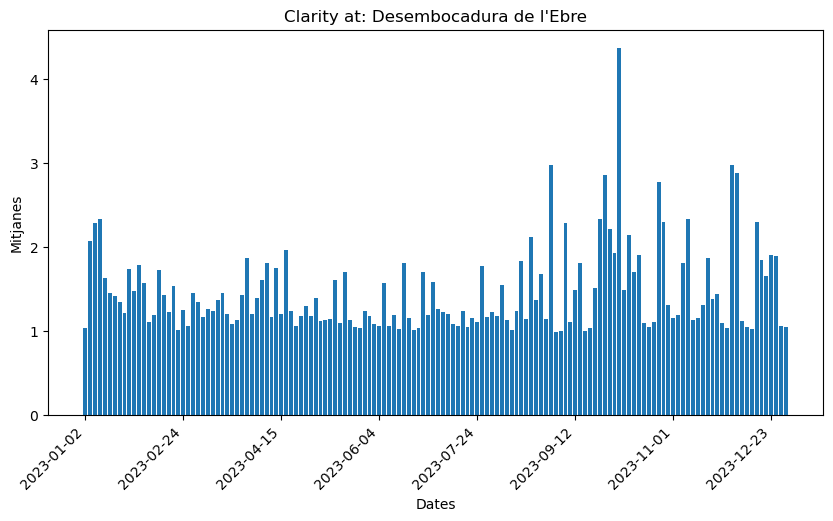

In [64]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt

fitxers = sorted([f for f in os.listdir(directory_data) if f.endswith('.tif')])

day_means_dict = {}

# --- Extraiem les dades dels fitxers, calculem les seves mitjanes diaries i les guardem en un diccionari
for fitxer in fitxers:
    # Extraiem la data i la mitjana diaria
    data = fitxer.split("_")[1].replace("Z.tif", "")
    with rasterio.open(directory_data+fitxer) as dades_fitxer:
        dades = dades_fitxer.read(1)  
        mitja = np.nanmean(dades)
        day_means_dict.update({data : mitja})
        
# --- Creem l'histograma
 
dates = list(day_means_dict.keys())
mitjes = list(day_means_dict.values())


plt.figure(figsize=(10, 5))
plt.bar(dates, mitjes)
plt.title(histogram_caption)
plt.xticks(ticks=range(0, len(dates), int(len(dates)/7)), labels=[dates[i] for i in range(0, len(dates), int(len(dates)/7))], rotation=45, ha="right")
plt.xlabel('Dates')
plt.ylabel('Mitjanes')

## 4. Creating an animation

Finaly we make an animation with all the recolected images.

MovieWriter ffmpeg unavailable; using Pillow instead.
TIFFReadDirectory: Warning, Unknown field with tag 33550 (0x830e) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 33922 (0x8482) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34735 (0x87af) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42112 (0xa480) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 33550 (0x830e) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 33922 (0x8482) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34735 (0x87af) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42112 (0xa480) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 33550 (0x830e) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 33922 (0x8482) encountered

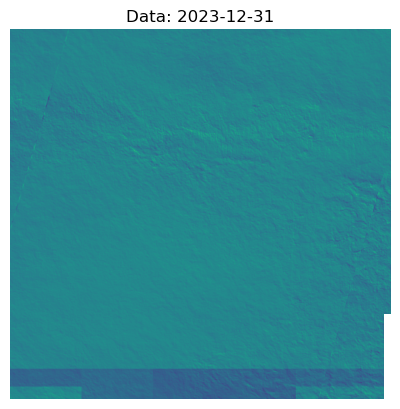

In [65]:
from libtiff import TIFF
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os

# Fem una llista amb tots els noms dels fitxers del directori d'imatges
image_files = sorted([f for f in os.listdir(directory_data) if f.endswith('.tif')])

def load_image(file_path):
    tif = TIFF.open(directory_data+file_path) 
    return tif.read_image()

# Create figure and axes
fig, ax = plt.subplots()

def update(frame):
    """Update the frame for the animation."""   
    
    rgb_image = load_image(image_files[frame])
    ax.clear()
    ax.imshow(rgb_image)
    ax.set_title(f"Data: {dates[frame]}")
    ax.axis('off')
    
ani = animation.FuncAnimation(fig, update, frames=len(image_files), repeat=True, interval=200)

# Save the animation as a gif or mp4
ani.save(animation_file, writer='ffmpeg', fps=2)


plt.show()